In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import datasets, metrics, model_selection, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import roc_curve, auc, roc_auc_score
import sklearn.metrics as metrics

In [2]:
from os import path
indir = '/cellar/users/hsher/course_project_2020/data'
col_list = ["sampleID","cancertype","cancerstage_cat","er_cat","pr_cat","her2_cat","chemo","datechemostart","datechemoend","daterecurrence","recurStatus"]
patient_info = pd.read_csv(path.join(indir, 'patient_info.csv'),usecols=col_list)

#patient_info.head

tpm = pd.read_csv(path.join(indir, 'tpm_96_nodup.tsv'), sep = '\t', index_col = 0)


readcounts = pd.read_csv(path.join(indir, 'readcounts_96_nodup.tsv'),sep='\t')

### k-folds validation

In [3]:
cv = StratifiedKFold(n_splits=4)

### With different models

In [4]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [5]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=20), 
    RandomForestClassifier(max_depth=20, n_estimators=50), # n_esti number of trees 
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [23]:
evaluate_metric = pd.DataFrame(index = names, columns = ['accuracy', 'sensitivity', 'specificity'])

In [60]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X.iloc[test,:])
from sklearn.metrics import classification_report
classification_report(y.iloc[test,:], y_pred, output_dict = True)['R']['recall']

0.8571428571428571

In [63]:
from sklearn.metrics import accuracy_score
def kfold(name, classifier, ax):
    ''' given model name, classifier, perform k-fold cross validation;
    return accuracy, sensitivity, specificity, auc, and roc curves'''
    
    # data for every fold is saved here
    accuracies = []
    sens = []
    specs = []
    fs = []
    aucs = []
    interpolated_tprs = [] # the curve
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv.split(X, y)):
        
        # fit model
        clf.fit(X.iloc[train,:], y.iloc[train,:])
        
        # accuracy
        y_pred = clf.predict(X.iloc[test,:])
        acc = accuracy_score(y_pred, y.iloc[test,:])
        accuracies.append(acc)
        
        # get roc curve
        viz = metrics.plot_roc_curve(clf, X.iloc[test,:], y.iloc[test,:],
                     name='ROC fold {}'.format(i),
                     alpha=0.3, lw=1, ax=ax)
        # get precision recall
        cls_metrics = classification_report(y.iloc[test,:], y_pred, output_dict = True)
        sen = cls_metrics['R']['recall']
        sens.append(sen)
        spec = cls_metrics['N']['recall']
        specs.append(spec)
        f = cls_metrics['R']['f1-score']
        fs.append(f)
        
        # return tpr
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        interpolated_tprs.append(interp_tpr)
        
        # area under curve
        aucs.append(viz.roc_auc)
    
    return accuracies, sens, specs, fs, aucs, interpolated_tprs
    

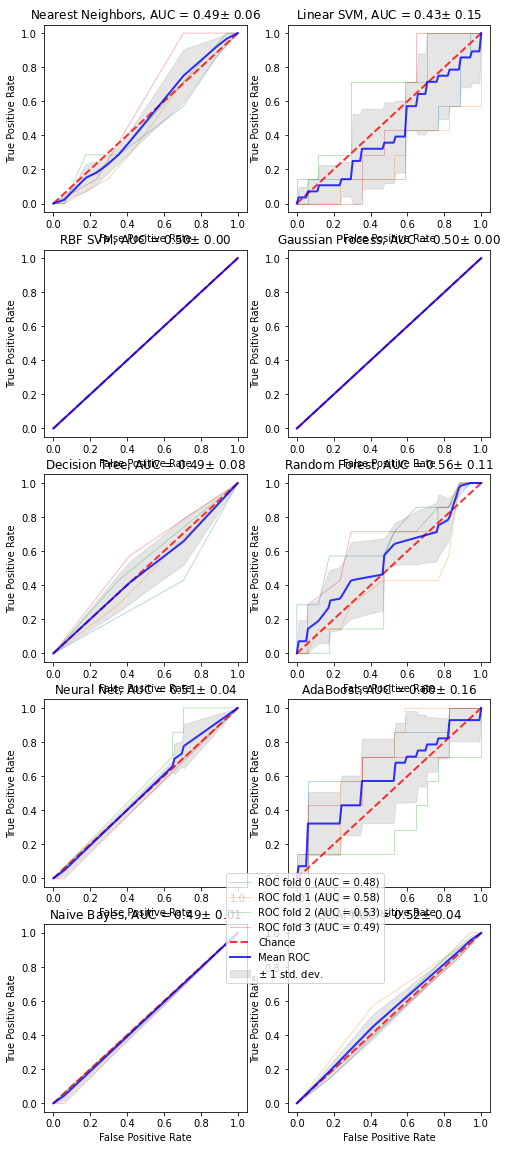

In [65]:
%matplotlib inline

eval_df = pd.DataFrame(index = names, columns = ['accuracy', 'sensitivity', 'specificity', 'f1', 'auc'])

X = tpm.T
y = patient_info[['recurStatus']]
cv = StratifiedKFold(n_splits=4)


fig, ax = plt.subplots(5, 2, figsize = (8,20))
ax = ax.flatten()


for k, (name, clf) in enumerate(zip(names, classifiers)):
    
    print('running ', name)
    
    accuracies, sens, specs, fs, aucs, tprs = kfold(name, clf, ax = ax[k])
    # save results
    eval_df.loc[name, 'accuracy'] = np.mean(accuracies)
    eval_df.loc[name, 'sensitivity'] = np.mean(sens)
    eval_df.loc[name, 'specificity'] = np.mean(specs)
    eval_df.loc[name, 'f1'] = np.mean(fs)
    eval_df.loc[name, 'auc'] = np.mean(aucs)
    
        
    
    # plot the diagnoal line
    ax[k].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
     
    # ROC curve mean
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[k].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC',
            lw=2, alpha=.8)
    
    
    # ROC curve std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[k].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    # set limit
    ax[k].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=name)
    ax[k].set_title('{}, AUC = {:.2f}$\pm$ {:.2f}'.format(name, mean_auc, std_auc))
    if k!=9:
        ax[k].get_legend().remove()
    else:
        # legend
        ax[k].legend(bbox_to_anchor=[0.5, 2.5])


In [66]:
eval_df

,accuracy,sensitivity,specificity,f1,auc
Nearest Neighbors,0.65625,0.107143,0.882353,0.121795,0.490546
Linear SVM,0.625,0.0357143,0.867647,0.0555556,0.430672
RBF SVM,0.708333,0,1,0,0.5
Gaussian Process,0.708333,0,1,0,0.5
Decision Tree,0.510417,0.428571,0.544118,0.33971,0.486345
Random Forest,0.697917,0,0.985294,0,0.556723
Neural Net,0.4375,0.678571,0.338235,0.334502,0.511555
AdaBoost,0.71875,0.214286,0.926471,0.297475,0.596639
Naive Bayes,0.697917,0,0.985294,0,0.492647
QDA,0.46875,0.642857,0.397059,0.380375,0.519958


In [19]:
len(tprs)

40

In [21]:
mean_fpr

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747